Task 1: Clustering

The final goal is clustering how users charge their cars based on:

* time of day
* day of the week

maybe
* charging station preference (location)
* overstaying past full-charge

In [548]:
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import timedelta
from permetrics import ClusteringMetric
from sklearn.cluster import DBSCAN
from scipy.stats import zscore

# Example usage
pd.set_option('display.width', 200)  # Adjust the width based on your screen size
pd.set_option('display.max_columns', None)  # Show all columns without truncation


In [549]:
# Load the CSV file
def load_csv(path_dataset):
    # Load data into a DataFrame
    data = pd.read_csv(path_dataset)
    return data


# Load data
path_dataset = "../data/EVChargingStationUsage.csv"
original_data = load_csv(path_dataset)
print(f"Dataset shape: {original_data.shape}\n\n")
original_data.head()


Dataset shape: (259415, 33)




/tmp/ipykernel_47210/3536394953.py:4: DtypeWarning: Columns (29,30,32) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(path_dataset)


,Station Name,MAC Address,Org Name,Start Date,Start Time Zone,End Date,End Time Zone,Transaction Date (Pacific Time),Total Duration (hh:mm:ss),Charging Time (hh:mm:ss),Energy (kWh),GHG Savings (kg),Gasoline Savings (gallons),Port Type,Port Number,Plug Type,EVSE ID,Address 1,City,State/Province,Postal Code,Country,Latitude,Longitude,Currency,Fee,Ended By,Plug In Event Id,Driver Postal Code,User ID,County,System S/N,Model Number
0,PALO ALTO CA / HAMILTON #1,000D:6F00:015A:9D76,City of Palo Alto,7/29/2011 20:17,PDT,7/29/2011 23:20,PDT,7/29/2011 23:20,3:03:32,1:54:03,6.249457,2.625,0.784,Level 2,2,J1772,NaN,250 Hamilton Ave,Palo Alto,California,94301,United States,37.444572,-122.160309,USD,0.0,Plug Out at Vehicle,3,95124.0,3284.0,NaN,NaN,NaN
1,PALO ALTO CA / HAMILTON #1,000D:6F00:015A:9D76,City of Palo Alto,7/30/2011 0:00,PDT,7/30/2011 0:02,PDT,7/30/2011 0:02,0:02:06,0:01:54,0.106588,0.045,0.013,Level 2,2,J1772,NaN,250 Hamilton Ave,Palo Alto,California,94301,United States,37.444572,-122.160309,USD,0.0,Customer,4,94301.0,4169.0,NaN,NaN,NaN
2,PALO ALTO CA / HAMILTON #1,000D:6F00:015A:9D76,City of Palo Alto,7/30/2011 8:16,PDT,7/30/2011 12:34,PDT,7/30/2011 12:34,4:17:32,4:17:28,14.951777,6.280,1.876,Level 2,2,J1772,NaN,250 Hamilton Ave,Palo Alto,California,94301,United States,37.444572,-122.160309,USD,0.0,Plug Out at Vehicle,5,94301.0,4169.0,NaN,NaN,NaN
3,PALO ALTO CA / HAMILTON #1,000D:6F00:015A:9D76,City of Palo Alto,7/30/2011 14:51,PDT,7/30/2011 16:55,PDT,7/30/2011 16:55,2:03:24,2:02:58,7.159643,3.007,0.899,Level 2,2,J1772,NaN,250 Hamilton Ave,Palo Alto,California,94301,United States,37.444572,-122.160309,USD,0.0,Customer,6,94302.0,2545.0,NaN,NaN,NaN
4,PALO ALTO CA / HAMILTON #1,000D:6F00:015A:9D76,City of Palo Alto,7/30/2011 18:51,PDT,7/30/2011 20:03,PDT,7/30/2011 20:03,1:11:24,0:43:54,1.957765,0.822,0.246,Level 2,2,J1772,NaN,250 Hamilton Ave,Palo Alto,California,94301,United States,37.444572,-122.160309,USD,0.0,Plug Out at Vehicle,7,94043.0,3765.0,NaN,NaN,NaN


Before we start cleaning the data, let's extract the features we're interested in

In [550]:
# features_df = original_data.head(30000).copy()  # Make a copy to avoid modification of the original data
features_df = original_data.copy()


# Use .loc to ensure you are modifying the DataFrame in a safe manner
features_df.loc[:, "Start Date"] = pd.to_datetime(features_df["Start Date"])
features_df.loc[:, "Charging Time (hh:mm:ss)"] = pd.to_timedelta(features_df["Charging Time (hh:mm:ss)"])
features_df.loc[:, "Total Duration (hh:mm:ss)"] = pd.to_timedelta(features_df["Total Duration (hh:mm:ss)"])

# Set the 'Start Date' column as the index
features_df = features_df.set_index("Start Date")
# features_df = features_df[features_df.index.year == 2020]

# Select specific columns
features_df = features_df[["User ID", "Station Name", "Energy (kWh)", "Total Duration (hh:mm:ss)", "Charging Time (hh:mm:ss)"]]

print(features_df.shape)
features_df.head()

(259415, 5)


/home/radugrecu97/dtu/semesters/1/business_analytics/Energy-and-Mobility/.venv/lib/python3.12/site-packages/pandas/core/indexes/base.py:7588: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)


,User ID,Station Name,Energy (kWh),Total Duration (hh:mm:ss),Charging Time (hh:mm:ss)
Start Date,,,,,
2011-07-29 20:17:00,3284.0,PALO ALTO CA / HAMILTON #1,6.249457,0 days 03:03:32,0 days 01:54:03
2011-07-30 00:00:00,4169.0,PALO ALTO CA / HAMILTON #1,0.106588,0 days 00:02:06,0 days 00:01:54
2011-07-30 08:16:00,4169.0,PALO ALTO CA / HAMILTON #1,14.951777,0 days 04:17:32,0 days 04:17:28
2011-07-30 14:51:00,2545.0,PALO ALTO CA / HAMILTON #1,7.159643,0 days 02:03:24,0 days 02:02:58
2011-07-30 18:51:00,3765.0,PALO ALTO CA / HAMILTON #1,1.957765,0 days 01:11:24,0 days 00:43:54


Let's check for type consistency

In [551]:
def check_dtypes(df):
    # Iterate over all columns in the DataFrame
    for column in df.columns:
        # Get the unique types in the column
        unique_types = df[column].apply(type).unique()
        
        # If the length of unique_types is greater than 1, the column has mixed data types
        if len(unique_types) > 1:
            print(f"The column '{column}' has mixed data types: {unique_types}")
        else:
            print(f"The column '{column}' has a consistent data type: {unique_types[0]}")

check_dtypes(features_df)

The column 'User ID' has mixed data types: [<class 'float'> <class 'str'>]
The column 'Station Name' has a consistent data type: <class 'str'>
The column 'Energy (kWh)' has a consistent data type: <class 'float'>
The column 'Total Duration (hh:mm:ss)' has a consistent data type: <class 'pandas._libs.tslibs.timedeltas.Timedelta'>
The column 'Charging Time (hh:mm:ss)' has a consistent data type: <class 'pandas._libs.tslibs.timedeltas.Timedelta'>


So it seems 'User ID' has mixed datatypes - floats and strings. The string values are either in non-decimal representation e.g. '154551' or they also contain a 'V' character at the end e.g. '263V'.

We'll convert all the floats to non-decimal representation and then to string.

There are also some entries with empty 'User ID':

In [552]:
def check_nan(df):
    for column in df.columns:
        print(column)
        # Filter the rows where column is NaN
        print(df[df[column].isna()])
        print("\n\n")

check_nan(features_df)


User ID
                    User ID                Station Name  Energy (kWh) Total Duration (hh:mm:ss) Charging Time (hh:mm:ss)
Start Date                                                                                                              
2012-10-13 07:12:00     NaN    PALO ALTO CA / BRYANT #1      3.006414           0 days 05:36:08          0 days 01:31:14
2012-10-13 18:54:00     NaN    PALO ALTO CA / BRYANT #1      7.763305           0 days 01:24:36          0 days 01:24:10
2012-10-14 13:38:00     NaN  PALO ALTO CA / HAMILTON #2      3.555682           0 days 01:01:53          0 days 01:01:40
2012-10-14 14:52:00     NaN      PALO ALTO CA / HIGH #4      3.555023           0 days 01:08:59          0 days 01:08:39
2012-10-14 18:45:00     NaN    PALO ALTO CA / BRYANT #1      1.139596           0 days 00:19:04          0 days 00:18:44
...                     ...                         ...           ...                       ...                      ...
2020-12-30 14:32:00     

Only 'User ID' column has Nan values.

7677 rows consists 2.9% of the total. Since we're interested in targeting individual users in the final model, we choose to drop it.

In another case, if we were interested in clustering overall charging station usage, it would make sense to keep these rows as the 'User ID' isn't relevant.

In [553]:
# Convert 'User ID' to integer for numeric values and leave non-numeric as is
def convert_to_int_if_numeric(value):
    try:
        # If the value is numeric, convert to int
        return int(float(value))
    except ValueError:
        # If it's not numeric (raises ValueError), leave it as it is
        return value
    
# Function to check if a value is numeric
def is_numeric(value):
    try:
        float(value)  # Try to convert the value to float
        return True    # If successful, it is numeric
    except ValueError:
        return False   # If an error occurs, it's not numeric


# # Remove rows with missing, invalid 'User D' and convert to int
features_clean_df = features_df.copy().dropna(subset=["User ID"])
features_clean_df["User ID"] = features_clean_df["User ID"].apply(convert_to_int_if_numeric)
features_clean_df = features_clean_df[features_clean_df["User ID"] != 0]

# Convert 'User ID' column to string type
features_clean_df["User ID"] = features_clean_df["User ID"].astype(str)
print(f"Converted Column\n\n{features_clean_df["User ID"]}\n\n")

# Filter the rows where 'User ID' is not numeric (non-numeric strings)
non_numeric = features_clean_df[~features_clean_df["User ID"].apply(is_numeric)]

# Print the non-numeric User IDs
print(f"Non-Numeric IDs\n{non_numeric[["User ID"]]}")

Converted Column

Start Date
2011-07-29 20:17:00       3284
2011-07-30 00:00:00       4169
2011-07-30 08:16:00       4169
2011-07-30 14:51:00       2545
2011-07-30 18:51:00       3765
                        ...   
2020-12-31 16:39:00    2024201
2020-12-31 16:48:00     242661
2020-12-31 17:28:00     449995
2020-12-31 17:49:00     804075
2020-12-31 18:19:00    2022651
Name: User ID, Length: 251285, dtype: object


Non-Numeric IDs
                     User ID
Start Date                  
2015-09-01 18:13:00     263V
2015-10-16 12:20:00     861V
2016-03-29 18:39:00     243V
2016-05-12 18:18:00     867V
2016-06-10 12:11:00    3683V
2016-08-04 15:16:00      86V
2016-08-30 16:02:00    5127V
2016-09-12 18:21:00     138V
2016-10-05 19:50:00     253V
2016-10-12 13:44:00    3363V
2016-10-14 09:30:00    3363V
2016-10-17 12:43:00    3363V
2016-10-18 10:35:00    3363V
2016-10-19 09:22:00    3363V
2017-03-15 12:38:00    6483V
2017-04-12 18:58:00     973V
2017-05-10 13:48:00    9353V
2017-07-01 19:24

In [554]:
check_dtypes(features_clean_df)

The column 'User ID' has a consistent data type: <class 'str'>
The column 'Station Name' has a consistent data type: <class 'str'>


The column 'Energy (kWh)' has a consistent data type: <class 'float'>
The column 'Total Duration (hh:mm:ss)' has a consistent data type: <class 'pandas._libs.tslibs.timedeltas.Timedelta'>
The column 'Charging Time (hh:mm:ss)' has a consistent data type: <class 'pandas._libs.tslibs.timedeltas.Timedelta'>


Now all the columns are consistent in data type.

In [555]:
print(features_clean_df.shape)
features_clean_df = features_clean_df.dropna()
print(features_clean_df.shape)

(251285, 5)
(251285, 5)


Remove invalid time values. Charging time cannot be less than Total Duration.

In [556]:
# Convert 'Total Duration (hh:mm:ss)' and 'Charging Time (hh:mm:ss)' from string to Timedelta
features_clean_df['Total Duration (hh:mm:ss)'] = pd.to_timedelta(features_clean_df['Total Duration (hh:mm:ss)'])
features_clean_df['Charging Time (hh:mm:ss)'] = pd.to_timedelta(features_clean_df['Charging Time (hh:mm:ss)'])

# Convert 'Total Duration' and 'Charging Time' to seconds
features_clean_df['Total Duration (seconds)'] = features_clean_df['Total Duration (hh:mm:ss)'].dt.total_seconds()
features_clean_df['Charging Time (seconds)'] = features_clean_df['Charging Time (hh:mm:ss)'].dt.total_seconds()

# Filter rows where Total Duration < Charging Time
filtered_df = features_clean_df[features_clean_df['Total Duration (seconds)'] > features_clean_df['Charging Time (seconds)']]


Data Preparation:

Split the charging events into 1 hour buckets.

In [557]:
import pandas as pd
import numpy as np
from datetime import timedelta

# Function to split the charging event into hours
def split_charging_events(row):
    start = row.name  # Access the index (Start Date)
    duration = row['Charging Time (hh:mm:ss)']
    total_energy = row['Energy (kWh)']
    
    hours = int(np.ceil(duration.total_seconds() / 3600))  # Total number of hour blocks
    results = []
    
    for i in range(hours):
        block_start = start.replace(minute=0, second=0, microsecond=0) + timedelta(hours=i)  # Set time to the top of the hour
        
        # Determine the duration for this block
        if i == 0:
            block_duration = min(timedelta(hours=1), duration)
        elif i == hours - 1:
            block_duration = duration - timedelta(hours=(hours - 1))
        else:
            block_duration = timedelta(hours=1)
        
        # Proportional energy calculation
        block_energy = total_energy * (block_duration.total_seconds() / duration.total_seconds())
        
        # Append a new row with split details
        results.append({
            'Start Date': block_start,
            'User ID': row['User ID'],
            'Energy (kWh)': block_energy
        })
    
    # Return a DataFrame for the split details of the current row
    return pd.DataFrame(results)

# # Apply the function to each row and concatenate results
# hourly_consumption_df = pd.concat([split_charging_events(row) for _, row in no_outliers_df.iterrows()], ignore_index=True)

# # Print final output
# hourly_consumption_df


Since we're more interested in daily and weekly patterns, we'll split the 'Start Date' into 'Hour' of the day and 'Day of the week'.
We start with 'Hour' of the day and average the energy usage by every user at every 'Hour'

In [558]:
# Assuming 'Start Date' is already a datetime column
deconstructed_df = filtered_df.copy()
deconstructed_df = deconstructed_df.reset_index()
deconstructed_df = deconstructed_df.set_index("User ID")

# Extract day of the week and hour into new columns
deconstructed_df['Hour'] = deconstructed_df['Start Date'].dt.hour  # Hour in 24-hour format
deconstructed_df['Day of Week'] = deconstructed_df['Start Date'].dt.day_name()  # Extract day of the week

# Convert 'Total Duration (hh:mm:ss)' and 'Charging Time (hh:mm:ss)' to seconds
deconstructed_df['Total Duration (seconds)'] = pd.to_timedelta(deconstructed_df['Total Duration (hh:mm:ss)']).dt.total_seconds()
deconstructed_df['Charging Time (seconds)'] = pd.to_timedelta(deconstructed_df['Charging Time (hh:mm:ss)']).dt.total_seconds()

# Drop the original 'hh:mm:ss' columns as they are no longer needed
deconstructed_df = deconstructed_df.drop(columns=['Start Date', 'Total Duration (hh:mm:ss)', 'Charging Time (hh:mm:ss)'])

# Group by 'User ID', 'Hour', 'Day of Week', 'Total Duration (seconds)', and 'Charging Time (seconds)'
deconstructed_df = deconstructed_df.groupby(
    ['User ID', 'Hour', 'Day of Week', 'Total Duration (seconds)', 'Charging Time (seconds)']
)['Energy (kWh)'].mean().reset_index()

# Set 'User ID' as the index again
deconstructed_df = deconstructed_df.set_index("User ID")

# Show the DataFrame
deconstructed_df

,Hour,Day of Week,Total Duration (seconds),Charging Time (seconds),Energy (kWh)
User ID,,,,,
1000031,18,Tuesday,13006.0,6347.0,4.959000
1000311,19,Friday,8682.0,8656.0,13.430000
100061V,7,Friday,3242.0,3198.0,5.253000
100061V,8,Thursday,21714.0,9406.0,15.016000
100061V,8,Tuesday,8641.0,8623.0,14.300000
...,...,...,...,...,...
99943,16,Tuesday,5205.0,5195.0,4.131000
99943,17,Friday,5946.0,5915.0,4.603000
99943,17,Friday,11117.0,11020.0,6.792509


Remove outliers in 'Total Duration' and 'Charging Time'

In [559]:
from scipy.stats import zscore

# Calculate z-scores for 'Total Duration' and 'Charging Time'
deconstructed_df['Total Duration z-score'] = zscore(deconstructed_df['Total Duration (seconds)'])
deconstructed_df['Charging Time z-score'] = zscore(deconstructed_df['Charging Time (seconds)'])

# Define a threshold for z-scores (e.g., 3 standard deviations)
z_threshold = 2

# Filter out rows where z-scores are beyond the threshold
filtered_df = deconstructed_df[
    (deconstructed_df['Total Duration z-score'].abs() <= z_threshold) &
    (deconstructed_df['Charging Time z-score'].abs() <= z_threshold)
].drop(columns=['Total Duration z-score', 'Charging Time z-score'])  # Drop z-score columns if no longer needed

filtered_df['Overstay ratio'] = filtered_df['Total Duration (seconds)'] / filtered_df['Charging Time (seconds)']

# Filter out rows where the 'Overstay ratio' is greater than X
filtered_df = filtered_df[filtered_df['Overstay ratio'] <= 4] # Drop the 'Overstay ratio' column if no longer needed


# Sort the DataFrame by 'Overstay ratio' in descending order
sorted_summary_df = filtered_df.sort_values(by='Overstay ratio', ascending=False)

# Display the sorted DataFrame
sorted_summary_df


,Hour,Day of Week,Total Duration (seconds),Charging Time (seconds),Energy (kWh),Overstay ratio
User ID,,,,,,
2944,16,Friday,6596.0,1649.0,1.179687,4.000000
719601,9,Wednesday,1196.0,299.0,0.485000,4.000000
784343,8,Sunday,188.0,47.0,0.050000,4.000000
110913,7,Monday,21136.0,5285.0,2.865944,3.999243
275953,7,Sunday,7271.0,1819.0,1.390482,3.997251
...,...,...,...,...,...,...
190825,16,Saturday,14468.0,14467.0,13.139721,1.000069
311727,18,Wednesday,14688.0,14687.0,23.798000,1.000068
4068171,16,Wednesday,14772.0,14771.0,24.692000,1.000068


In [560]:
dated_df = filtered_df.copy()

# Create a binary feature that is 1 for Saturday and Sunday, and 0 otherwise
dated_df['Weekend'] = dated_df['Day of Week'].isin(['Saturday', 'Sunday']).astype(int)

# Group by 'User ID' and 'Weekend', then calculate the total energy consumption by weekend/weekday
energy_by_weekend_df = dated_df.groupby(['User ID', 'Weekend'])['Energy (kWh)'].sum().unstack(fill_value=0)

# Rename the columns for clarity
energy_by_weekend_df.columns = ['Weekday Energy (kWh)', 'Weekend Energy (kWh)']

# Sum 'Total Duration (seconds)' and 'Charging Time (seconds)' for each user (not split by Weekend)
total_duration_and_charging_df = dated_df.groupby('User ID').agg(
    {'Total Duration (seconds)': 'sum', 'Charging Time (seconds)': 'sum'}
)

# Combine the two DataFrames into one
summary_df = pd.concat([energy_by_weekend_df, total_duration_and_charging_df], axis=1)
summary_df


,Weekday Energy (kWh),Weekend Energy (kWh),Total Duration (seconds),Charging Time (seconds)
User ID,,,,
1000031,4.959000,0.000000,13006.0,6347.0
1000311,13.430000,0.000000,8682.0,8656.0
100061V,34.569000,0.000000,33597.0,21227.0
10013,11.177250,0.000000,9455.0,9375.0
100161V,33.824000,0.000000,25733.0,22418.0
...,...,...,...,...
998031,55.794000,0.000000,36452.0,36398.0
99823,12.548339,1.860996,18907.0,17541.0
998481,12.360000,0.000000,10247.0,8203.0


In [561]:
summary_ratio_df = summary_df.copy()
# summary_ratio_df['Overstay ratio'] = summary_ratio_df['Total Duration (seconds)'] / summary_ratio_df['Charging Time (seconds)']
summary_ratio_df['Overstay ratio'] = np.log(summary_ratio_df['Total Duration (seconds)'] / summary_ratio_df['Charging Time (seconds)'])

# Define a small epsilon to avoid division by zero
epsilon = 1e-9

# Compute the logarithmic difference between weekday and weekend energy
# Log(Weekday Energy / Weekend Energy) will be positive if weekday energy is higher, and negative if weekend energy is higher
summary_ratio_df['Energy Difference Log'] = np.log(summary_ratio_df['Weekday Energy (kWh)'] + epsilon) - np.log(summary_ratio_df['Weekend Energy (kWh)'] + epsilon)

# Drop columns no longer needed
summary_ratio_df = summary_ratio_df.drop(columns=['Weekday Energy (kWh)', 'Weekend Energy (kWh)', 'Total Duration (seconds)', 'Charging Time (seconds)'])

# Display the resulting DataFrame
summary_ratio_df

# Values close to 1: Strong preference for weekday charging.
# Values close to −1: Strong preference for weekend charging.

,Overstay ratio,Energy Difference Log
User ID,,
1000031,0.717429,22.324470
1000311,0.002999,23.320757
100061V,0.459163,24.266223
10013,0.008497,23.137146
100161V,0.137910,24.244436
...,...,...
998031,0.001482,24.744932
99823,0.074991,1.908476
998481,0.222485,23.237731


Standardize the average 'Energy (kWh)'

In [562]:
# Copy the original DataFrame to avoid modifying it directly
summary_ratio_std_df = summary_ratio_df.copy()

# Standardize only the 'Energy (kWh)' column
scaler = StandardScaler()
summary_ratio_std_df['Overstay ratio'] = scaler.fit_transform(summary_ratio_std_df[['Overstay ratio']])
summary_ratio_std_df['Energy Preference Ratio'] = scaler.fit_transform(summary_ratio_std_df[['Energy Difference Log']])
# Display the resulting DataFrame
summary_ratio_std_df


,Overstay ratio,Energy Difference Log,Energy Preference Ratio
User ID,,,
1000031,3.322354,22.324470,0.924379
1000311,-0.517056,23.320757,0.979681
100061V,1.934410,24.266223,1.032162
10013,-0.487510,23.137146,0.969489
100161V,0.207967,24.244436,1.030953
...,...,...,...
998031,-0.525207,24.744932,1.058735
99823,-0.130164,1.908476,-0.208877
998481,0.662481,23.237731,0.975073


In [563]:
def print_elbow_plot(scaled_df, title_suffix):
    wcss = []  # List to store within-cluster sum of squares

    # Calculate WCSS for cluster numbers ranging from 1 to 10
    for i in range(1, 11):
        kmeans = KMeans(n_clusters=i)
        kmeans.fit(scaled_df)
        wcss.append(kmeans.inertia_)  # Inertia: Sum of squared distances of samples to the closest cluster center

    # Plot the elbow curve
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
    plt.title(f'Optimal Number of Clusters for {title_suffix}')
    plt.xticks(np.arange(1, 11, 1))  # Ensure all cluster numbers are shown
    plt.grid(True)
    plt.show()

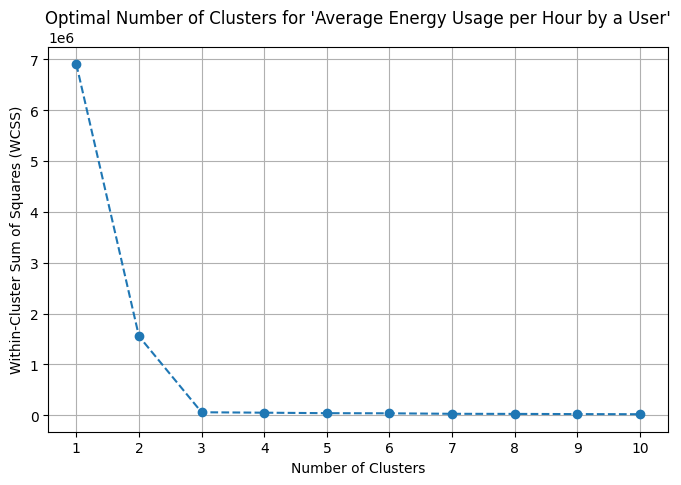

In [564]:
print_elbow_plot(summary_ratio_std_df, "'Average Energy Usage per Hour by a User'")

In [565]:
def print_kmeans(df, scaled_df, n_clusters, x_name, y_name, x_label, y_label, title):
    # Apply KMeans clustering
    kmeans = KMeans(n_clusters=n_clusters)
    
    # Fit the model and predict clusters
    df['Cluster'] = kmeans.fit_predict(scaled_df)

    # Ensure scaled_df is a NumPy array for ClusteringMetric
    scaled_array = scaled_df.to_numpy()
    
    # Initialize ClusteringMetric for evaluation
    cm = ClusteringMetric(X=scaled_array, y_pred=df['Cluster'].values)
    
    # Compute DBCV score
    dbcv_score = cm.density_based_clustering_validation_index()
    
    # Scatter plot with KMeans clusters
    plt.figure(figsize=(10, 6))
    sns.scatterplot(
        x=df[x_name],
        y=df[y_name],
        hue=df['Cluster'],
        palette=sns.color_palette(),  # Clearer color palette
        s=12,
        alpha=0.5
    )

    # Set X-axis ticks for 'Hour' labels
    if x_name == 'Hour':
        plt.xticks(range(0, 24))
    
    # Add labels and title
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)

    # Add DBCV score as text on the plot
    plt.text(0.95, 0.95, f'DBCV Score: {dbcv_score:.2f}', 
             horizontalalignment='right', verticalalignment='top', 
             transform=plt.gca().transAxes, fontsize=12, color='black')

    plt.legend(title='Cluster')
    plt.show()


/tmp/ipykernel_47210/3964721575.py:19: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  sns.scatterplot(


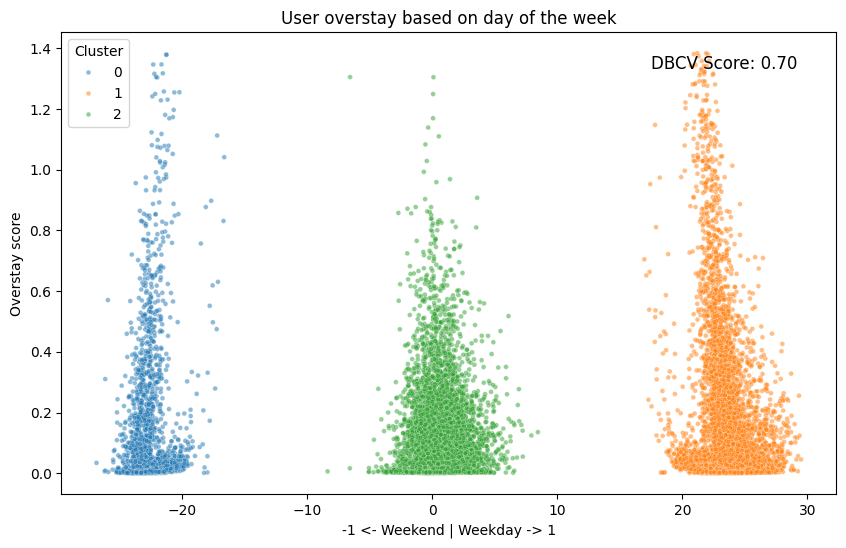

In [566]:
print_kmeans(df=summary_ratio_df,
             scaled_df=summary_ratio_std_df,
             n_clusters=3,
             x_name="Energy Difference Log",
             y_name="Overstay ratio",
             x_label="-1 <- Weekend | Weekday -> 1",
             y_label="Overstay score",
             title="User overstay based on day of the week")

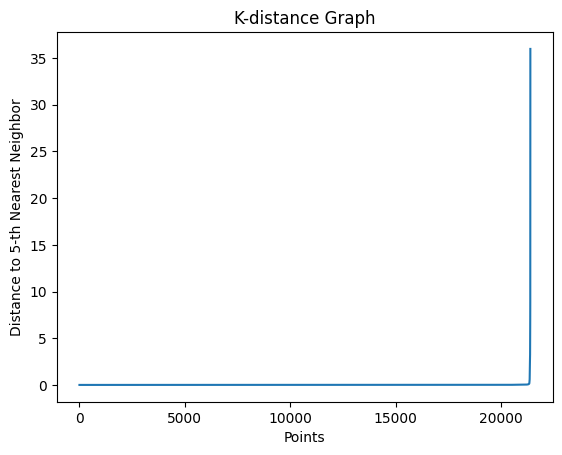

In [567]:
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'data' is your dataset
min_samples = 5  # Typically start with 4 or 5
nbrs = NearestNeighbors(n_neighbors=min_samples).fit(energy_by_weekend_std_df)
distances, indices = nbrs.kneighbors(energy_by_weekend_std_df)

# Sort distances for each point and plot
distances = np.sort(distances[:, -1], axis=0)

# Plot k-distance graph
plt.plot(distances)
plt.title('K-distance Graph')
plt.xlabel('Points')
plt.ylabel(f'Distance to {min_samples}-th Nearest Neighbor')
plt.show()


In [568]:

def print_dbscan(scaled_df, eps, min_samples, x, y, xlabel, ylabel, title):
    # Apply DBSCAN clustering
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    
    # Fit the DBSCAN model and predict clusters
    df['Cluster'] = dbscan.fit_predict(scaled_df)
    
    # Initialize ClusteringMetric for evaluation
    cm = ClusteringMetric(X=scaled_df, y_pred=df['Cluster'].values)
    
    # Compute DBCV score
    dbcv_score = cm.density_based_clustering_validation_index()  # You can also use cm.DBCVI()
    
    # Scatter plot with DBSCAN clusters
    plt.figure(figsize=(10, 6))
    sns.scatterplot(
        x=df[x],
        y=df[y],
        hue=df['Cluster'],
        palette=sns.color_palette(),
        s=15  # Optional: size of points
    )

    # Set X-axis ticks to show all hours (0 to 23) - optional based on data
    plt.xticks(range(0, 24))  # Ensure all hours are shown on the X-axis

    # Add labels and title
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)

    # Add DBCV score as text on the plot
    plt.text(0.95, 0.95, f'DBCV Score: {dbcv_score:.2f}', 
             horizontalalignment='right', verticalalignment='top', 
             transform=plt.gca().transAxes, fontsize=12, color='black')

    plt.legend(title='Cluster')
    plt.show()


In [569]:
print_dbscan(df=mean_energy_per_hour,
             eps=,
             min_samples=,
             x="Hour",
             y="Energy (kWh)",
             xlabel="Hour of the day",
             ylabel="Average energy consumption(kWh)",
             title="Average Energy Consumption per hour by user")

SyntaxError: expected argument value expression (3228055131.py, line 2)

Cluster the users that always charge at peak hours, when most stations are in use at each location

Data preprocessing:

Station name will be one-hot encoded.
Charging time will be converted to seconds.